In [1]:
%pylab inline
pylab.rcParams['figure.figsize'] = (16.0, 8.0)
from PyDynamic import GUM_DFT

Populating the interactive namespace from numpy and matplotlib


# DFT and inverse DFT with PyDynamic - best practice guide

The discrete Fourier transform (DFT) and its inverse (iDFT) are common tools in dynamic metrology. For the corresponding propagation of uncertainties, *PyDynamic* implements the main tools required:

**Uncertainty propagation for the discrete Fourier transform**
```python 
    GUM_DFT(x,Ux,N=None,window=None,CxCos=None,CxSin=None,returnC=False,mask=None)
```

**Uncertainty propagation for the inverse discrete Fourier transform**
```python
    GUM_iDFT(F,UF,Nx=None,Cc=None,Cs=None,returnC=False)
```

**Uncertainty propagation for convolution in the frequency domain**
```python
    DFT_multiply(Y, UY, F, UF=None)
```

**Uncertainty propagation for deconvolution in the frequency domain**
```python
    DFT_deconv(H, Y, UH, UY)
```

In the following we discuss common use cases for these methods and present guidance on how to utilize the optional arguments of the above methods.

## 1) Discrete Fourier Transform (DFT)

The first and most basic scenario is the application of the discrete Fourier transform to analyse a time domain signal in the frequency domain. 

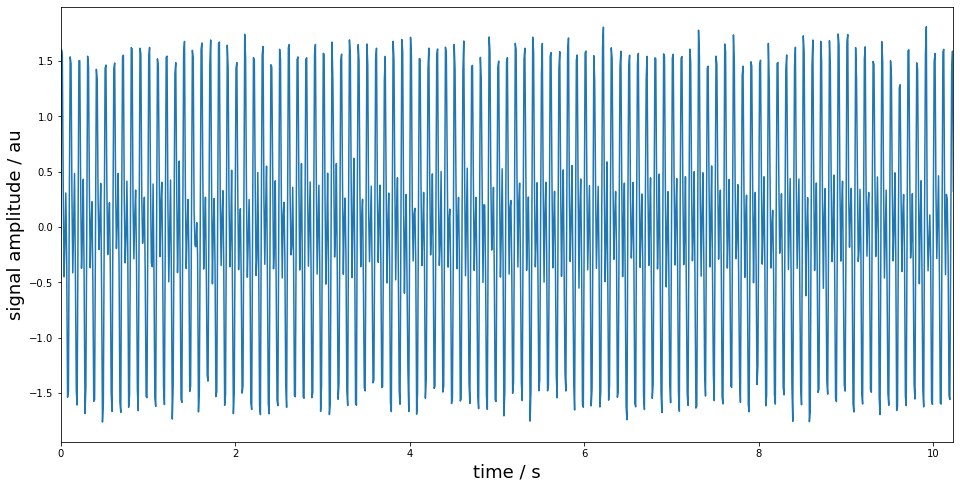

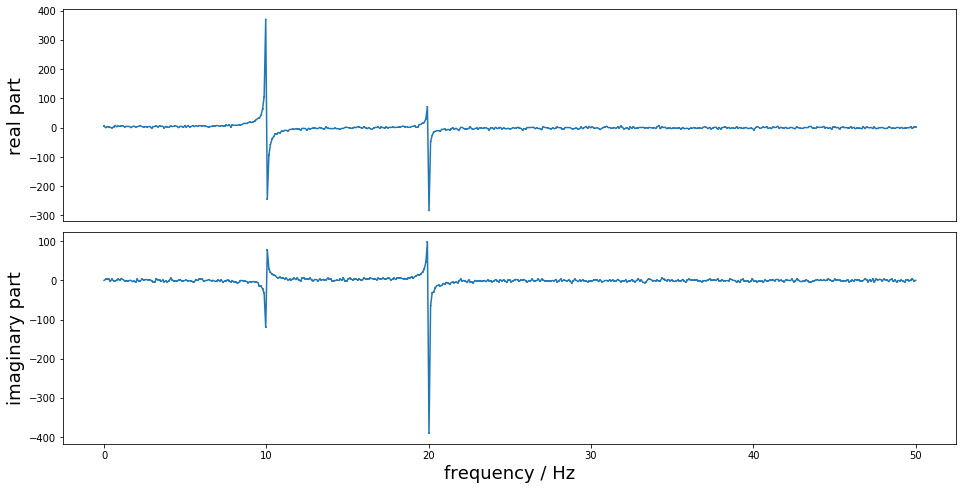

In [2]:
Fs = 100    # sampling frequency in Hz
Ts = 1/Fs   # sampling interval in s
N  = 1024   # number of samples
time = arange(0, N*Ts, Ts)  # time instants
noise_std = 0.1    # signal noise standard deviation
# time domain signal
x = sin(2*pi*Fs/10*time) + sin(2*pi*Fs/5*time) + random.randn(len(time))*noise_std

X, UX = GUM_DFT(x, noise_std**2)    # application of DFT with propagation of uncertainties
f = fft.rfftfreq(N, Ts)   # frequency values

figure()
plot(time, x)
xlim(time[0], time[-1])
xlabel("time / s", fontsize=18)
ylabel("signal amplitude / au", fontsize=18);

figure()
subplot(211)
errorbar(f, X[:len(f)], sqrt(UX[:len(f)]))
ylabel("real part", fontsize=18)
xticks([])
subplot(212)
errorbar(f, X[len(f):], sqrt(UX[len(f):]))
ylabel("imaginary part", fontsize=18)
xlabel("frequency / Hz", fontsize=18)
subplots_adjust(hspace=0.05)